In [1]:
import psrchive
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths
from scipy.optimize import curve_fit
import scipy.optimize as opt
from scipy.cluster.vq import kmeans, vq 
import scipy.stats as stats
from scipy.stats import vonmises
from scipy import signal
from matplotlib import gridspec

### Define the Functions

In [2]:
#This function is used to insert an array before the last element of another array (created partly by ChatGPT)
def insert_array_before_last(arr, array_to_insert):
    if len(arr) >= 1:
        index_to_insert = len(arr) - 1
        array_to_insert_without_last = array_to_insert[:-1]  # Remove the last element
        arr = np.insert(arr, index_to_insert, array_to_insert_without_last)
        return arr
    else:
        print("The array must have at least one element to insert before the last index.")

In [3]:
def map_to_degrees(array):
    max_value = max(array)
    degrees_array = [(value / max_value) * 360 for value in array]
    return degrees_array

In [4]:
#This function is used to smooth the data
def smoothTriangle(data, degree):
    triangle=np.concatenate((np.arange(degree + 1), np.arange(degree)[::-1])) # up then down
    smoothed=[]

    for i in range(degree, len(data) - degree * 2):
        point=data[i:i + len(triangle)] * triangle
        smoothed.append(np.sum(point)/np.sum(triangle))
    # Handle boundaries
    smoothed=[smoothed[0]]*int(degree + degree/2) + smoothed
    while len(smoothed) < len(data):
        smoothed.append(smoothed[-1])
    return smoothed

In [5]:
def calculate_rms(array):
    """
    Calculate the Root Mean Square (RMS) of an array of values.

    Parameters:
    - array (numpy.ndarray): Input array of values.

    Returns:
    - float: RMS value.
    
    Function created partly by ChatGPT
    """
    if len(array) == 0:
        raise ValueError("Input array is empty")

    # Square each element in the array
    squared_values = np.square(array)

    # Calculate the mean of the squared values
    mean_squared = np.mean(squared_values)

    # Calculate the square root of the mean squared value
    rms = np.sqrt(mean_squared)

    return rms

In [6]:
#Define a Gaussian and its different parameters
def gaussian(x, amp1,cen1,sigma1,b):
    #return amp1*(1/(sigma1*(np.sqrt(2*np.pi))))*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + b
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + b

In [7]:
#Define a profile with 4 aded gaussians
def _2gaussian(x, A1, p1, w1, A2, p2, w2, b):
#    return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
#            A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + b

In [8]:
#Define a profile with 4 aded gaussians
def _3gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + b

In [9]:
#Define a profile with 4 aded gaussians
def _4gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + b
     return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) + b

In [10]:
#Define a profile with 5 added gaussians
def _5gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + \
    #           A5*np.exp(-4*np.log(2)*((x-p5)/w5)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + \
     gaussian(x, A4, p4, w4, 0) +  gaussian(x, A5, p5, w5, 0) + b

In [11]:
#Define a profile with 6 added gaussians
def _6gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + \
    #           A5*np.exp(-4*np.log(2)*((x-p5)/w5)**2) + \
    #            A6*np.exp(-4*np.log(2)*((x-p6)/w6)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) + \
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + b

In [12]:
#Define a profile with 7 added gaussians
def _7gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6, A7, p7, w7, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + \
    #           A5*np.exp(-4*np.log(2)*((x-p5)/w5)**2) + \
    #            A6*np.exp(-4*np.log(2)*((x-p6)/w6)**2) + \
    #             A7*np.exp(-4*np.log(2)*((x-p7)/w7)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) + \
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + gaussian(x, A7, p7, w7, 0) + b

In [13]:
#Define a profile with 8 added gaussians
def _8gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6, A7, p7, w7, A8, p8, w8, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + \
    #           A5*np.exp(-4*np.log(2)*((x-p5)/w5)**2) + \
    #            A6*np.exp(-4*np.log(2)*((x-p6)/w6)**2) + \
    #             A7*np.exp(-4*np.log(2)*((x-p7)/w7)**2) + \
    #              A8*np.exp(-4*np.log(2)*((x-p8)/w8)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) +\
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + gaussian(x, A7, p7, w7, 0) + gaussian(x, A8, p8, w8, 0) + b

In [14]:
#Define a profile with 9 added gaussians
def _9gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6, A7, p7, w7, A8, p8, w8, A9, p9, w9, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + \
    #           A5*np.exp(-4*np.log(2)*((x-p5)/w5)**2) + \
    #            A6*np.exp(-4*np.log(2)*((x-p6)/w6)**2) + \
    #             A7*np.exp(-4*np.log(2)*((x-p7)/w7)**2) + \
    #              A8*np.exp(-4*np.log(2)*((x-p8)/w8)**2) + \
    #               A9*np.exp(-4*np.log(2)*((x-p9)/w9)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) +\
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + gaussian(x, A7, p7, w7, 0) + gaussian(x, A8, p8, w8, 0) +\
            gaussian(x, A9, p9, w9, 0) + b

In [15]:
#Define a profile with 10 added gaussians
def _10gaussian(x, A1, p1, w1, A2, p2, w2, A3, p3, w3, A4, p4, w4, A5, p5, w5, A6, p6, w6,\
                A7, p7, w7, A8, p8, w8, A9, p9, w9, A10, p10, w10, b):
    #return A1*np.exp(-4*np.log(2)*((x-p1)/w1)**2) + \
    #        A2*np.exp(-4*np.log(2)*((x-p2)/w2)**2) + \
    #         A3*np.exp(-4*np.log(2)*((x-p3)/w3)**2) + \
    #          A4*np.exp(-4*np.log(2)*((x-p4)/w4)**2) + \
    #           A5*np.exp(-4*np.log(2)*((x-p5)/w5)**2) + \
    #            A6*np.exp(-4*np.log(2)*((x-p6)/w6)**2) + \
    #             A7*np.exp(-4*np.log(2)*((x-p7)/w7)**2) + \
    #              A8*np.exp(-4*np.log(2)*((x-p8)/w8)**2) + \
    #               A9*np.exp(-4*np.log(2)*((x-p9)/w9)**2) + \
    #                A10*np.exp(-4*np.log(2)*((x-p10)/w10)**2) + b
    return gaussian(x, A1, p1, w1, 0) + gaussian(x, A2, p2, w2, 0) + gaussian(x, A3, p3, w3, 0) + gaussian(x, A4, p4, w4, 0) +\
            gaussian(x, A5, p5, w5, 0) + gaussian(x, A6, p6, w6, 0) + gaussian(x, A7, p7, w7, 0) + gaussian(x, A8, p8, w8, 0) +\
            gaussian(x, A9, p9, w9, 0) + gaussian(x, A10, p10, w10, 0) + b

In [16]:
#This function deterrmines which number of added gaussians to return depending on the iteration
def which_gauss(i, xdata, p0_arr):
        gauss_arr = []
        if i == 1:
            gauss_arr = gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3])
        elif i == 2:
            gauss_arr = _2gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6])
        elif i == 3:
            gauss_arr = _3gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9])
        elif i == 4:
            gauss_arr = _4gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12])
        elif i == 5:
            gauss_arr = _5gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15])
        elif i == 6:
            gauss_arr = _6gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18])    
        elif i == 7:
            gauss_arr = _7gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18], p0_arr[19], p0_arr[20], p0_arr[21])
        elif i == 8:
            gauss_arr = _8gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18], p0_arr[19], p0_arr[20], p0_arr[21], p0_arr[22], p0_arr[23],\
                              p0_arr[24])  
        elif i == 9:
            gauss_arr = _9gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18], p0_arr[19], p0_arr[20], p0_arr[21], p0_arr[22], p0_arr[23],\
                              p0_arr[24], p0_arr[25], p0_arr[26], p0_arr[27])          
        elif i == 10:
            gauss_arr = _10gaussian(xdata, p0_arr[0], p0_arr[1], p0_arr[2], p0_arr[3], p0_arr[4], p0_arr[5], p0_arr[6], p0_arr[7],\
                              p0_arr[8], p0_arr[9], p0_arr[10], p0_arr[11], p0_arr[12], p0_arr[13], p0_arr[14], p0_arr[15],\
                              p0_arr[16], p0_arr[17], p0_arr[18], p0_arr[19], p0_arr[20], p0_arr[21], p0_arr[22], p0_arr[23],\
                              p0_arr[24], p0_arr[25], p0_arr[26], p0_arr[27], p0_arr[28], p0_arr[29], p0_arr[30])
        return(gauss_arr)


In [17]:
#Define the function to minimize with the least_squares algorithm
def fit_func(p, x, y):
    if np.any(p<0):
        return np.inf
    return y - gaussian(x, *p)

In [18]:
#Define a function which does all the plotting
def plotting(iteration, original_data, x, param_arr, on_pulse, resids, first_cutoff, last_cutoff, pulse_center, \
             show_all = False):
            #Get the array for the Gaussian which will be plotted
            gaussian_plot = which_gauss(iteration, x, param_arr)
            
            #Create subplots to plot both the data compared to the original data and the residuals
            fig, axs = plt.subplots(2, 1)
            fig.set_figheight(10)
            fig.set_figwidth(10)

            axs[0].plot(x, gaussian_plot, color='blue', label='Fit')
            axs[0].plot(x, original_data, color='silver', label='Original Data')
            axs[0].plot(x, on_pulse, color='green', label='Fitted Data')
            axs[0].axvline(x=first_cutoff, color = 'r', label='First Cutoff Line')
            axs[0].axvline(x=last_cutoff, color = 'darkred', label='Last Cutoff Line')
            axs[0].axvline(x=pulse_center, color='r', linestyle='--', label='Pulse Center')
            axs[0].set_title('Resulting Fit', fontsize=10)
            axs[0].set_xlabel('Pulse Phase [deg]', fontsize=10)
            axs[0].set_ylabel('Intensity [arbitrary units]', fontsize=10)
            axs[0].legend()

            axs[1].plot(x, resids, label='Residuals')
            axs[1].axis('auto')
            #axs[1, 0].set(xlim=(-3, 3), ylim=(-3, 3))
            axs[1].set_title('Residuals', fontsize=10)
            axs[1].set_xlabel('Pulse Phase [deg]', fontsize=10)
            axs[1].set_ylabel('Intensity [arbitrary units]', fontsize=10)
            axs[1].legend()

            plt.show()
            plt.close()
        
            #--------------------------
            
            #Create a new figure to plot all of the separate Gaussians
            plt.figure(figsize=(12,6))
            
            #Depeding on the amount of Gaussians, find how many to plot and plot them
            if show_all == True:
                if iteration == 1:                   
                    pars_1 = param_arr[0:3]
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
            
                    plt.plot(on_pulse, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
        
                elif iteration == 2:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_added = _2gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[-1])
                
                    plt.plot(on_pulse, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
            
                elif iteration == 3:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_added = _3gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[-1])
            
            
                    plt.plot(on_pulse, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
            
                elif iteration == 4:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_added = _4gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[-1])
            
            
                    plt.plot(on_pulse, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                    
            
                elif iteration == 5:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_added = _5gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[-1])
                    
                    #plt.figure().set_figheight(5)
                    #plt.figure().set_figwidth(10)
                    plt.plot(on_pulse, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                                
                elif iteration == 6:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_added = _6gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[-1])
            
                
                    plt.plot(on_pulse, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                    
                elif iteration == 7:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
                    pars_7 = param_arr[18:21]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_peak7 = gaussian(x, *pars_7, param_arr[-1])
                    gauss_added = _7gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[18], param_arr[19], param_arr[20], param_arr[-1])
                    
            
                    plt.plot(on_pulse, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_peak7, label='Gaussian 7')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                    
                elif iteration == 8:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
                    pars_7 = param_arr[18:21]
                    pars_8 = param_arr[21:24]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_peak7 = gaussian(x, *pars_7, param_arr[-1])
                    gauss_peak8 = gaussian(x, *pars_8, param_arr[-1])
                    gauss_added = _8gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[18], param_arr[19], param_arr[20], param_arr[21], param_arr[22], \
                               param_arr[23], param_arr[-1])
            
                    plt.plot(on_pulse, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_peak7, label='Gaussian 7')
                    plt.plot(x, gauss_peak8, label='Gaussian 8')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                
                elif iteration == 9:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
                    pars_7 = param_arr[18:21]
                    pars_8 = param_arr[21:24]
                    pars_9 = param_arr[24:27]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_peak7 = gaussian(x, *pars_7, param_arr[-1])
                    gauss_peak8 = gaussian(x, *pars_8, param_arr[-1])
                    gauss_peak9 = gaussian(x, *pars_9, param_arr[-1])
                    gauss_added = _9gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[18], param_arr[19], param_arr[20], param_arr[21], param_arr[22], \
                               param_arr[23], param_arr[24], param_arr[25], param_arr[26], param_arr[-1])
                    
            
                    plt.plot(on_pulse, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_peak7, label='Gaussian 7')
                    plt.plot(x, gauss_peak8, label='Gaussian 8')
                    plt.plot(x, gauss_peak9, label='Gaussian 9')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
                    
                elif iteration == 10:
                    pars_1 = param_arr[0:3]
                    pars_2 = param_arr[3:6]
                    pars_3 = param_arr[6:9]
                    pars_4 = param_arr[9:12]
                    pars_5 = param_arr[12:15]
                    pars_6 = param_arr[15:18]
                    pars_7 = param_arr[18:21]
                    pars_8 = param_arr[21:24]
                    pars_9 = param_arr[24:27]
                    pars_10 = param_arr[27:30]
            
                    gauss_peak1 = gaussian(x, *pars_1, param_arr[-1])
                    gauss_peak2 = gaussian(x, *pars_2, param_arr[-1])
                    gauss_peak3 = gaussian(x, *pars_3, param_arr[-1])
                    gauss_peak4 = gaussian(x, *pars_4, param_arr[-1])
                    gauss_peak5 = gaussian(x, *pars_5, param_arr[-1])
                    gauss_peak6 = gaussian(x, *pars_6, param_arr[-1])
                    gauss_peak7 = gaussian(x, *pars_7, param_arr[-1])
                    gauss_peak8 = gaussian(x, *pars_8, param_arr[-1])
                    gauss_peak9 = gaussian(x, *pars_9, param_arr[-1])
                    gauss_peak10 = gaussian(x, *pars_10, param_arr[-1])
                    gauss_added = _10gaussian(x, param_arr[0], param_arr[1], param_arr[2], param_arr[3], param_arr[4],\
                               param_arr[5], param_arr[6], param_arr[7], param_arr[8], param_arr[9], param_arr[10],\
                               param_arr[11], param_arr[12], param_arr[13], param_arr[14], param_arr[15], param_arr[16], \
                               param_arr[17], param_arr[18], param_arr[19], param_arr[20], param_arr[21], param_arr[22], \
                               param_arr[23], param_arr[24], param_arr[25], param_arr[26], param_arr[27], param_arr[28], \
                               param_arr[29], param_arr[-1])
            
                    plt.plot(on_pulse, 'r', label='Data')
                    plt.plot(x, gauss_peak1, label='Gaussian 1')
                    plt.plot(x, gauss_peak2, label='Gaussian 2')
                    plt.plot(x, gauss_peak3, label='Gaussian 3')
                    plt.plot(x, gauss_peak4, label='Gaussian 4')
                    plt.plot(x, gauss_peak5, label='Gaussian 5')
                    plt.plot(x, gauss_peak6, label='Gaussian 6')
                    plt.plot(x, gauss_peak7, label='Gaussian 7')
                    plt.plot(x, gauss_peak8, label='Gaussian 8')
                    plt.plot(x, gauss_peak9, label='Gaussian 9')
                    plt.plot(x, gauss_peak10, label='Gaussian 10')
                    plt.plot(x, gauss_added, label='Added Gauss')
                    plt.axvline(x=first_cutoff, color = 'r')
                    plt.axvline(x=last_cutoff, color = 'r')
                    plt.axvline(x=pulse_center, color='r', linestyle='--')
            
            
            #Plot parameters
            plt.title('All Single Gaussian + Data')
            plt.xlabel('Pulse Phase [Bins]')
            plt.ylabel('Intensity [arbitrary units]')
            plt.legend()
            plt.show()
            plt.close()

#### Fitting Algorithm

In [19]:
def select_longest_range_above_cutoff(data, cutoff, min_consecutive_above=3):
    above_threshold = data >= cutoff

    max_start = -1
    max_end = -1
    current_start = -1
    current_end = -1
    max_length = 0
    current_length = 0

    for i, above in enumerate(above_threshold):
        if above:
            current_length += 1
            if current_start == -1:
                current_start = i
            current_end = i
        else:
            if current_length >= min_consecutive_above:
                if current_length > max_length:
                    max_start = current_start
                    max_end = current_end
                    max_length = current_length
            current_length = 0
            current_start = -1
            current_end = -1

    # Check if the last sequence is the longest
    if current_length >= min_consecutive_above and current_length > max_length:
        max_start = current_start
        max_end = current_end

    return data[max_start:max_end + 1], max_start, max_end

In [53]:
def gauss_fit(data, k, iteration, param_arr, resids_params, mean_baseline = False, smooth = False, remove_baseline = True):
    force_smooth = False
    resids = []
    popt_gauss = []
    gauss_arr = []
    #Create a copy of the original data
    original_data = data[k]
    #Simplify the data so we don't have to call k every time
    data = data[k]
    #Select the index of the max of ydata
    arrmax = np.argmax(data)
    #Select the max value in the y data
    max_value = data[arrmax]
    #Calculate % of that max value that will be the cutoff for the fit
    cutoff = max_value*0.10
    
    print(data)
    print(np.shape(data))
    
    #x_list = np.linspace(0,len(data),len(data))
    #x = map_to_degrees(x_list)
    
    
    #Option to smooth the data in order to allow for easier fitting
    if smooth == True:
        #smooth triangle algorithm
        data = smoothTriangle(data, 4)
        #savgol filter for smoothing
        #data = signal.savgol_filter(data, len(on_pulse), 5) # order of fitted polynomial
    
    #Declare some arrays that we will want to use after the follow if-statement
    off_pulse_mean = []
    first_cutoff = []
    last_cutoff = []
    off_pulse_mean_normalized = []
    
    #if-statement that removes any baseline to the data
    if remove_baseline == True:
        #Cutoff value which defines what the baseline is
        baseline_cutoff = 0.20
        cutoff_index_temp = []
        #Make a list of the indexes of the values in the data which are lower than the cutoff
        for idx, i in enumerate(data):
            if i >= baseline_cutoff:
                cutoff_index_temp.append(idx)
                
        #Determine first and last value where the on pulse starts and stops
        first_cutoff = cutoff_index_temp[0]
        last_cutoff = cutoff_index_temp[-1]
        #Remove the on pulse from the data
        off_pulse = np.delete(data,(np.r_[first_cutoff:last_cutoff]))
        #Calculate the RMS of the off_pulse
        off_pulse_rms = calculate_rms(off_pulse) 
        #Find the mean value of the off pulse
        off_pulse_mean = np.mean(off_pulse)
        #Apply the removal of the baseline
        data = data - off_pulse_mean
        
        #Select the frequency channel number to normalise
        data_current = data
        #Perform the normalisation from 0 to 1 on the y axis
        data_normalized = (data_current - np.min(data_current))/(np.max(data_current) - np.min(data_current))
        #Append normalized value to array for normalized values
        data = data_normalized
        
        #Now we want the mean value of the baseline once it has been normalized
        off_pulse_normalized = np.delete(data,(np.r_[first_cutoff:last_cutoff]))
        off_pulse_mean_normalized = np.mean(off_pulse_normalized)
        
    #These lines set all the baseline to the mean value
    if mean_baseline == True:
        #data[data < baseline_cutoff] = off_pulse_mean_normalized
        #print('Baseline_Cutoff: ' + str(baseline_cutoff))
        data_last_idx = len(data) -1
        data[np.r_[0:first_cutoff,last_cutoff:data_last_idx]] = off_pulse_mean_normalized
    
    cutoff_index = []

    on_pulse_arr, first_cutoff, last_cutoff = select_longest_range_above_cutoff(data, cutoff)
    #print('on_pulse_arr_new len: ' + str(len(on_pulse_arr_new)))
    plt.plot(on_pulse_arr)
    plt.show()
    plt.close()
    #print(start_cutoff)
    
    #print('new cutoffs data length: ' + str(len(data[int(start_cutoff):int(end_cutoff)+1])))
    
    #Create an array to select only on-pulse
    #on_pulse_arr = []
    #for i in data:
    #    if i >= cutoff:
    #        on_pulse_arr = np.append(on_pulse_arr, i)
    
    #Create an array with the indexes of the on pulse
    #for idx, i in enumerate(data):
    #    if i >= cutoff:
    #        cutoff_index = np.append(cutoff_index, idx)
            
    #Get the first and last index of the on pulse
    #first_cutoff = x[int(cutoff_index[0])]
    #last_cutoff = x[int(cutoff_index[-1])]
    #first_cutoff = int(cutoff_index[0])
    #last_cutoff = int(cutoff_index[-1])
    #Get the center index of the pulse
    pulse_center = (first_cutoff + last_cutoff)/2
      
    
    #Define a list of x values
    x = np.arange(len(data))
    x_on_pulse = np.arange(len(on_pulse_arr))
    print('On Pulse length: ' + str(len(on_pulse_arr)))
    print('Cutoff Array length: ' + str(len(data[first_cutoff:last_cutoff])))
    #print('On Pulse max: ' + str(max(on_pulse_arr)))
    #print('On Pulse x: ' + str(len(x_on_pulse)))
    #print('On Pulse Index at max: ' + str(np.argmax(on_pulse_arr)))
    #print('On Pulse Sigma: ' + str(round(len(on_pulse_arr)/5)))
    print('x_on_pulse length: ' +str(len(x_on_pulse)))
    #print('on_pulse_arr:' + str(on_pulse_arr))

    #Set the guesses for the initial parameters
    initial_amp = 1.0
    initial_sigma = round(len(on_pulse_arr)/5)
    initial_center = np.argmax(on_pulse_arr)
    initial_b = 0
    initial_guess = []
    initial_guess = [initial_amp, initial_center, initial_sigma, initial_b]
    
    #Append the appropriate guess parameters to the appropriate array
    if iteration == 2:
        initial_guess2 = []
        initial_guess2 = insert_array_before_last(param_arr, resids_params)
    elif iteration == 3:
        initial_guess3 = []
        initial_guess3 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 4:
        initial_guess4 = []
        initial_guess4 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 5:    
        initial_guess5 = []
        initial_guess5 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 6:    
        initial_guess6 = []
        initial_guess6 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 7:    
        initial_guess7 = []
        initial_guess7 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 8:    
        initial_guess8 = []
        initial_guess8 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 9:    
        initial_guess9 = []
        initial_guess9 = np.append(initial_guess[:-1], param_arr)
    elif iteration == 10:    
        initial_guess10 = []
        initial_guess10 = np.append(initial_guess[:-1], param_arr)

    #Set the bounds on the fitting algorithm
    len_arr = len(on_pulse_arr)
    bounds1 = ((cutoff,0,0,0), (np.inf, len(on_pulse_arr), len(on_pulse_arr), np.min(on_pulse_arr)))
    bounds2 = ((cutoff,0,0,cutoff,0,0,0), (np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf,\
                len(on_pulse_arr), len(on_pulse_arr),np.min(on_pulse_arr)))
    bounds3 = ((cutoff,0,0,cutoff,0,0,cutoff,0,0,0), \
               (np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), \
                len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.min(on_pulse_arr)))
    bounds4 = ((cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,0), \
               (np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf,len(on_pulse_arr), len(on_pulse_arr), np.min(on_pulse_arr)))
    bounds5 = ((cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,0), \
               (np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr),\
                len(on_pulse_arr), np.min(on_pulse_arr)))
    bounds6 = ((cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,0), \
               (np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr),np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.min(on_pulse_arr)))
    bounds7 = ((cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,0), \
               (np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.min(on_pulse_arr)))
    bounds8 = ((cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,0), \
               (np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.min(on_pulse_arr)))
    bounds9 = ((cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,0), \
               (np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.min(on_pulse_arr)))
    bounds10 = ((cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,cutoff,0,0,0), \
               (np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.inf, \
                len(on_pulse_arr), len(on_pulse_arr), np.inf, len(on_pulse_arr), len(on_pulse_arr), np.min(on_pulse_arr)))
    
    #Here we run the fitting code given the appropriate parameters
    if iteration == 1:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess, bounds=bounds1, method='trf', maxfev=1000000)
        gauss_arr = gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3])
    elif iteration == 2:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_2gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess2, bounds=bounds2, method='trf', maxfev=1000000)
        gauss_arr = _2gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4], popt_gauss[5], popt_gauss[6])
    elif iteration == 3:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_3gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess3, bounds=bounds3, method='trf', maxfev=1000000)
        gauss_arr = _3gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9])
    elif iteration == 4:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_4gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess4, bounds=bounds4, method='trf', maxfev=1000000)
        gauss_arr = _4gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12])
    elif iteration == 5:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_5gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess5, bounds=bounds5, method='trf', maxfev=1000000)
        gauss_arr = _5gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15])
    elif iteration == 6:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_6gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess6, bounds=bounds6, method='trf', maxfev=1000000)
        gauss_arr = _6gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18])
    elif iteration == 7:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_7gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess7, bounds=bounds7, method='trf', maxfev=1000000)
        gauss_arr = _7gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18], popt_gauss[19], popt_gauss[20], popt_gauss[21])
    elif iteration == 8:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_8gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess8, bounds=bounds8, method='trf', maxfev=1000000)
        gauss_arr = _8gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18], popt_gauss[19], popt_gauss[20], popt_gauss[21],\
                               popt_gauss[22], popt_gauss[23], popt_gauss[24])
    elif iteration == 9:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_9gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess9, bounds=bounds9, method='trf', maxfev=1000000)
        gauss_arr = _9gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18], popt_gauss[19], popt_gauss[20], popt_gauss[21],\
                               popt_gauss[22], popt_gauss[23], popt_gauss[24], popt_gauss[25], popt_gauss[26], popt_gauss[27])
    elif iteration == 10:
        #Use the trf algorithm to estimate the final fit parameters
        popt_gauss, pcov_gauss = opt.curve_fit(_10gaussian, x_on_pulse, on_pulse_arr, p0=initial_guess10, bounds=bounds10, method='trf', maxfev=1000000)
        gauss_arr = _10gaussian(x, popt_gauss[0], popt_gauss[1], popt_gauss[2], popt_gauss[3], popt_gauss[4],\
                               popt_gauss[5], popt_gauss[6], popt_gauss[7], popt_gauss[8], popt_gauss[9], popt_gauss[10],\
                               popt_gauss[11], popt_gauss[12], popt_gauss[13], popt_gauss[14], popt_gauss[15],\
                               popt_gauss[16], popt_gauss[17], popt_gauss[18], popt_gauss[19], popt_gauss[20], popt_gauss[21],\
                               popt_gauss[22], popt_gauss[23], popt_gauss[24], popt_gauss[25], popt_gauss[26], popt_gauss[27],\
                               popt_gauss[28], popt_gauss[29], popt_gauss[30])
    else:
        #We stop after 10 Gaussian fits
        print("Trying to fit more than 10 Gaussians... There is most likely a problem...")
        resids = [100]
        print("Forcing smoothing of the profile to try to get a better fit")
        #Set force_smooth to true so that we can try again with smoothed data
        force_smooth = True
        return(resids, popt_gauss, gauss_arr, on_pulse_arr, off_pulse_rms, x, resids_params, first_cutoff, last_cutoff, pulse_center, \
           force_smooth)     
    
    #on_pulse_resulting_gauss = gauss_arr[int(first_cutoff):int(last_cutoff)+1]
    shift_amount = int(first_cutoff)
    gauss_arr_full = np.roll(gauss_arr, shift_amount)
    
    #Get the residuals
    resids = data - gauss_arr_full
    
    plt.plot(gauss_arr_full, label = 'fit')
    plt.plot(data, label = 'data')
    plt.title('test plot')
    plt.legend()
    plt.show()
    plt.close()
    
    #Allow for smoothing of residuals
    if smooth == True:
        resids = smoothTriangle(resids, 2)
        
    #Here we will take the resulting residuals and fit a Gaussian to it in order to use these parameters in the next fit
    #bounds_resids = ((cutoff,0,0,0), (np.inf, len(on_pulse_arr), len(on_pulse_arr), np.min(on_pulse_arr)))
    bounds_resids = ((np.max(resids)*0.50,0,len(resids)/1000,np.min(resids)), (np.inf, len(resids), round(len(resids)/2), 0.5))
    guess_resids = [np.max(resids), np.argmax(resids), round(len(resids)/5), 0]
    resids_params, pcov_resids = opt.curve_fit(gaussian, x, resids, p0=guess_resids, bounds=bounds_resids, method='trf', maxfev=1000000)
    #Print the fit parameters returned by the fir algorithm
    resids_gauss_arr = gaussian(x, resids_params[0], resids_params[1], resids_params[2], resids_params[3])
    
    plt.plot(resids_gauss_arr)
    plt.plot(resids)
    plt.show()
    plt.close()

    
    print('Max resids: ' + str(np.max(resids)))
    print('Off- Pulse rms: ' + str(off_pulse_rms))
    
    return(resids, popt_gauss, gauss_arr, on_pulse_arr, off_pulse_rms, x, resids_params, first_cutoff, last_cutoff, pulse_center, \
           force_smooth)

-------------------------------------------------------------------------------------------

In [21]:
def calculate_snr(array, signal_start, signal_end):
    #Function created in part by ChatGPT
    intensity = np.nanmean(array, axis=0)
    time = np.arange(0, len(intensity))
    noise_start = 0
    noise_end = len(time)

    # Find the indices corresponding to the signal and noise regions
    signal_indices = np.where((time >= signal_start) & (time <= signal_end))[0]
    noise_indices = np.where((time >= noise_start) & (time <= noise_end))[0]

    # Calculate the signal level (average intensity in signal region)
    signal_level = np.nanmean(intensity[signal_indices]) if len(signal_indices) > 0 else np.nan

    # Calculate the noise level (standard deviation of intensity in noise region)
    noise_level = np.nanstd(intensity[noise_indices]) if len(noise_indices) > 0 else np.nan

    # Calculate SNR
    snr = signal_level / noise_level if noise_level != 0 else np.inf

    return(snr)

In [22]:
def calculate_fwhm(dataset):
    max_value = max(dataset)
    half_max = max_value / 2

    # Find the indices where the dataset crosses the half-maximum value
    indices = [index for index, value in enumerate(dataset) if value >= half_max]

    if len(indices) >= 2:
        fwhm = indices[-1] - indices[0] + 1
        return fwhm
    else:
        return None

In [23]:
def calculate_fwhm_between_cutoffs(dataset, first_cutoff, last_cutoff):
    # Find the indices within the specified cutoff range
    indices = [index for index, value in enumerate(dataset) if first_cutoff <= value <= last_cutoff]

    if len(indices) >= 2:
        fwhm = indices[-1] - indices[0] + 1
        return fwhm
    else:
        return None

In [24]:
def split_array_into_subarrays(main_array, num_elements_per_subarray = 3):
    num_subarrays = len(main_array) // num_elements_per_subarray
    subarrays = []

    for i in range(num_subarrays):
        start_index = i * num_elements_per_subarray
        end_index = start_index + num_elements_per_subarray
        subarray = main_array[start_index:end_index]
        subarrays.append(subarray)

    return subarrays  

In [25]:
def find_min_max_y_subarrays(subarrays):
    min_y_index = None
    max_y_index = None
    min_y_value = float('inf')
    max_y_value = float('-inf')
    
    for i, subarray in enumerate(subarrays):
        y_value = subarray[1]  # Assuming y value is at index 1
        if y_value < min_y_value:
            min_y_value = y_value
            min_y_index = i
        if y_value > max_y_value:
            max_y_value = y_value
            max_y_index = i
            
    if min_y_index is not None and max_y_index is not None:
        return subarrays[min_y_index], subarrays[max_y_index]
    else:
        return None, None

In [26]:
#Determine the left component and the right component
def determine_components(params):
    b = params[-1]
    params_no_b = params[:-1]
    subarrays = split_array_into_subarrays(params_no_b)
    
    # Initialize these arrays as Python lists
    min_y_subarray = []
    max_y_subarray = []
    
    # Append the 'b' value to the subarrays
    min_y_subarray, max_y_subarray = find_min_max_y_subarrays(subarrays)
    
    # Calculate the subarrays with min and max y values
    min_y_subarray = np.append(min_y_subarray, b)
    max_y_subarray = np.append(max_y_subarray, b)
    
    return(min_y_subarray, max_y_subarray)

In [27]:
def width_uncert(data, x, first_cutoff, last_cutoff, params):
    snr = calculate_snr(data, first_cutoff, last_cutoff) #on_pulse_mean/noise_std #Need to create these variables
    min_center_subarray, max_center_subarray = determine_components(params)
    min_gauss = gaussian(x, *min_center_subarray)
    max_gauss = gaussian(x, *max_center_subarray)
    Wl = calculate_fwhm(min_gauss) #FWHM of left outermost component
    Wr = calculate_fwhm(max_gauss) #FWHM of righ outermost component
    Rl = min_center_subarray[0] #Amplitude of left outermost component
    Rr = max_center_subarray[0] #Ampliturde of right outermost component
    uncert1 = Wl/(4*Rl*np.log(1/Rl)*snr)
    uncert2 = Wr/(4*Rr*np.log(1/Rr)*snr)
    uncert_full = np.sqrt(uncert1**2 + uncert2**2)
    return(uncert_full)

### Load Data

In [28]:
# Load data
a = psrchive.Archive_load('/srv/storage_11/galc/UBB/jtremblay/20220913/added_clean/B0355+54_added.ar.10chns.pazi')
a.tscrunch()
a.dedisperse()
a.pscrunch()
a.remove_baseline()
data = a.get_data()
print("data shape: " + str(data.shape))

data shape: (1, 1, 10, 1024)


In [29]:
# Get weights
ww = np.array(a.get_weights(), dtype=bool)
# Create array with only True with same shape as data
wts = np.ones(data.shape, dtype=bool)
print("ww shape: " + str(np.shape(ww)))
print("wts shape: " + str(np.shape(wts)))

ww shape: (1, 10)
wts shape: (1, 1, 10, 1024)


In [30]:
# If True in ww, set to false in wts
# Essentially, creates the opposite of ww
wts[...,ww,:] = False

In [31]:
# set all values in data with True in wts to nan
mata = data.copy()
mata[wts] = np.nan

In [32]:
#Create an array to store the normalized values
mata_norm = []
#Select only the arrays we are interested in
matadata = mata[0,0,:]

#For loop used to normalize channels between 0 and 40
for i in range(0,10):
    #Select the frequency channel number to normalise
    matadata_current = matadata[i]
    #Perform the normalisation from 0 to 1 on the y axis
    mata_normalized = (matadata_current - np.min(matadata_current))/(np.max(matadata_current) - np.min(matadata_current))
    #Append normalized value to array for normalized values
    mata_norm.append(mata_normalized)

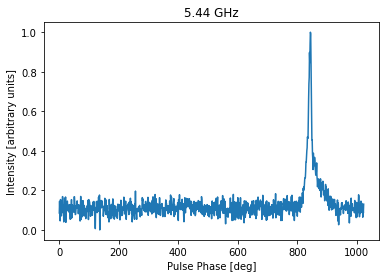

In [33]:
#Choose which profile to plot
k = 5
#Plot the normalized data
plt.plot(mata_norm[k])
plt.title('5.44 GHz')
plt.xlabel('Pulse Phase [deg]')
plt.ylabel('Intensity [arbitrary units]')
plt.show()

### Run the code

Iteration #1
[0.01771744 0.01790741 0.01499777 ... 0.00945394 0.00973256 0.01857228]
(1024,)


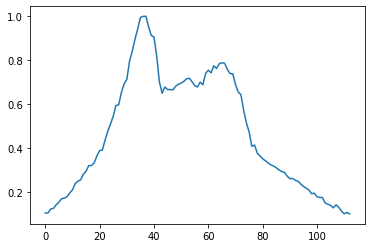

On Pulse length: 113
Cutoff Array length: 112
x_on_pulse length: 113


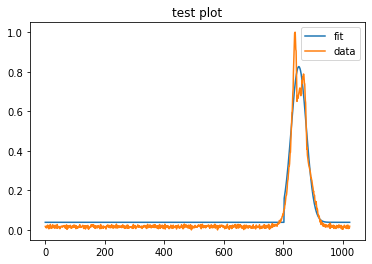

ValueError: operands could not be broadcast together with shapes (1024,) (4,) 

In [54]:
#def iterate_fit(data, k, smooth = False):
    k = 0
    data = mata_norm
    smooth = False
    resids = []
    resids_percent = False
    iteration = 1
    param_arr = []
    resids_params = []
    mean_baseline = False
    show_all = True
    #Iterate through fitting code while adding a gaussian every time until residuals are less than 5%
    while resids_percent == False:
                   
        print('Iteration #' + str(iteration))
        resids, param_arr, fit_arr, on_pulse, off_pulse_rms, x, resids_params, first_cutoff, last_cutoff, pulse_center, \
        force_smooth = gauss_fit(data, k, iteration, param_arr, resids_params, mean_baseline, smooth)

        if (force_smooth == True) and (smooth == True) and (iteration == 11):
            print('Unable to create a fit with 10 Gaussians and smoothed profiles.')
            if mean_baseline == False:
                print('Will now average all off-pulse values to their mean value.')
                mean_baseline = True
                iteration = 1
            elif mean_baseline == True:
                print('Tried all options, no fit is possible')
                resids_percent = True
        #If the residuals are smaller than 5% we stop, if they are larger we iterate again
        #elif (max(resids)< 0.20) and (min(resids) > -0.20):
        elif (max(np.abs(resids)) < off_pulse_rms) or ((max(resids)< 0.05) and (min(resids) > -0.05)):
            resids_percent = True
            print("The residuals are less than 5%")
            plotting(iteration, data[k], x, param_arr, on_pulse, resids, first_cutoff, last_cutoff, pulse_center, show_all)
        else:
            resids_percent = False
            print("The residuals are more than 5%")
            iteration = iteration + 1
            if force_smooth == True:
                iteration = 1
                smooth = True

    gaussian_added = fit_arr
    fwhm = calculate_fwhm(gaussian_added)
    plt.plot(x, gaussian_added)
    print(gaussian_added)
    uncertainties = width_uncert(data, x, first_cutoff, last_cutoff, param_arr)
    print(fwhm, uncertainties)
#uncert_width = width_uncert(data[k], first_cutoff, last_cutoff)

In [35]:
uncertainties = width_uncert(data, x, first_cutoff, last_cutoff, param_arr)
print(uncertainties)

IndexError: list index out of range

In [ ]:
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
fwhm_arr = [51, 17,  14, 14, 14, 14, 14, 15, 14, 14]
fwhm_err = [13.001944977638274, 13.08933679660062, 22.049231977712417, 15.103296049094556, 14.966809235802526, 15.488491895513677, 15.048725146593313, 12.844194720924085, 13.272772061871816, 12.490160137041775]
plt.errorbar(x, fwhm_arr, yerr=fwhm_err, fmt='.')
plt.xlabel('Frequency Channel')
plt.ylabel('FWHM of Peak [Bins]')